In [28]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [29]:
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

age-gender-and-ethnicity-face-data-csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [31]:
import zipfile
zip_ref = zipfile.ZipFile('/content/age-gender-and-ethnicity-face-data-csv.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [32]:
data = pd.read_csv("/content/age_gender.csv")
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [33]:
df = data.drop('img_name', axis=1)
df.head()

,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


In [34]:
def basic_eda(df):
    print("\n Shape: ")
    print(df.shape)
    print("\n\n --------- ")
    print("\n Number of null values: ")
    print(df.isnull().sum())
    print("\n\n --------- ")
    print("\n Value count of age: ")
    print(df['age'].value_counts())
    print("\n\n --------- ")
    print("\n Value count of ethnicity: ")
    print(df['ethnicity'].value_counts())
    print("\n\n --------- ")
    print("\n Value count of gender: ")
    print(df['gender'].value_counts())

In [35]:
basic_eda(df)


 Shape: 
(23705, 4)


 --------- 

 Number of null values: 
age          0
ethnicity    0
gender       0
pixels       0
dtype: int64


 --------- 

 Value count of age: 
26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
111       1
103       1
Name: age, Length: 104, dtype: int64


 --------- 

 Value count of ethnicity: 
0    10078
1     4526
3     3975
2     3434
4     1692
Name: ethnicity, dtype: int64


 --------- 

 Value count of gender: 
0    12391
1    11314
Name: gender, dtype: int64


In [36]:
# Dividing target variables
columns = ["age", "gender", "ethnicity"]
y = df.drop("pixels", axis=1)
X = df.drop(columns, axis=1)

In [37]:
X.head()

,pixels
0,129 128 128 126 127 130 133 135 139 142 145 14...
1,164 74 111 168 169 171 175 182 184 188 193 199...
2,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,193 197 198 200 199 200 202 203 204 205 208 21...
4,202 205 209 210 209 209 210 211 212 214 218 21...


In [38]:
y.head()

,age,ethnicity,gender
0,1,2,0
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0


In [39]:
y.nunique()

age          104
ethnicity      5
gender         2
dtype: int64

In [40]:
num_pixels = len(X['pixels'][0].split(" "))
img_height = int(np.sqrt(len(X['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(X['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


In [41]:
X = pd.Series(X['pixels'])
X = X.apply(lambda x:x.split(' '))
X = X.apply(lambda x:np.array(list(map(lambda z:np.int(z), x))))
X = np.array(X)
X = np.stack(np.array(X), axis=0)

# reshape data
X = X.reshape(-1, 48, 48, 1)
print("X shape: ", X.shape)

X shape:  (23705, 48, 48, 1)


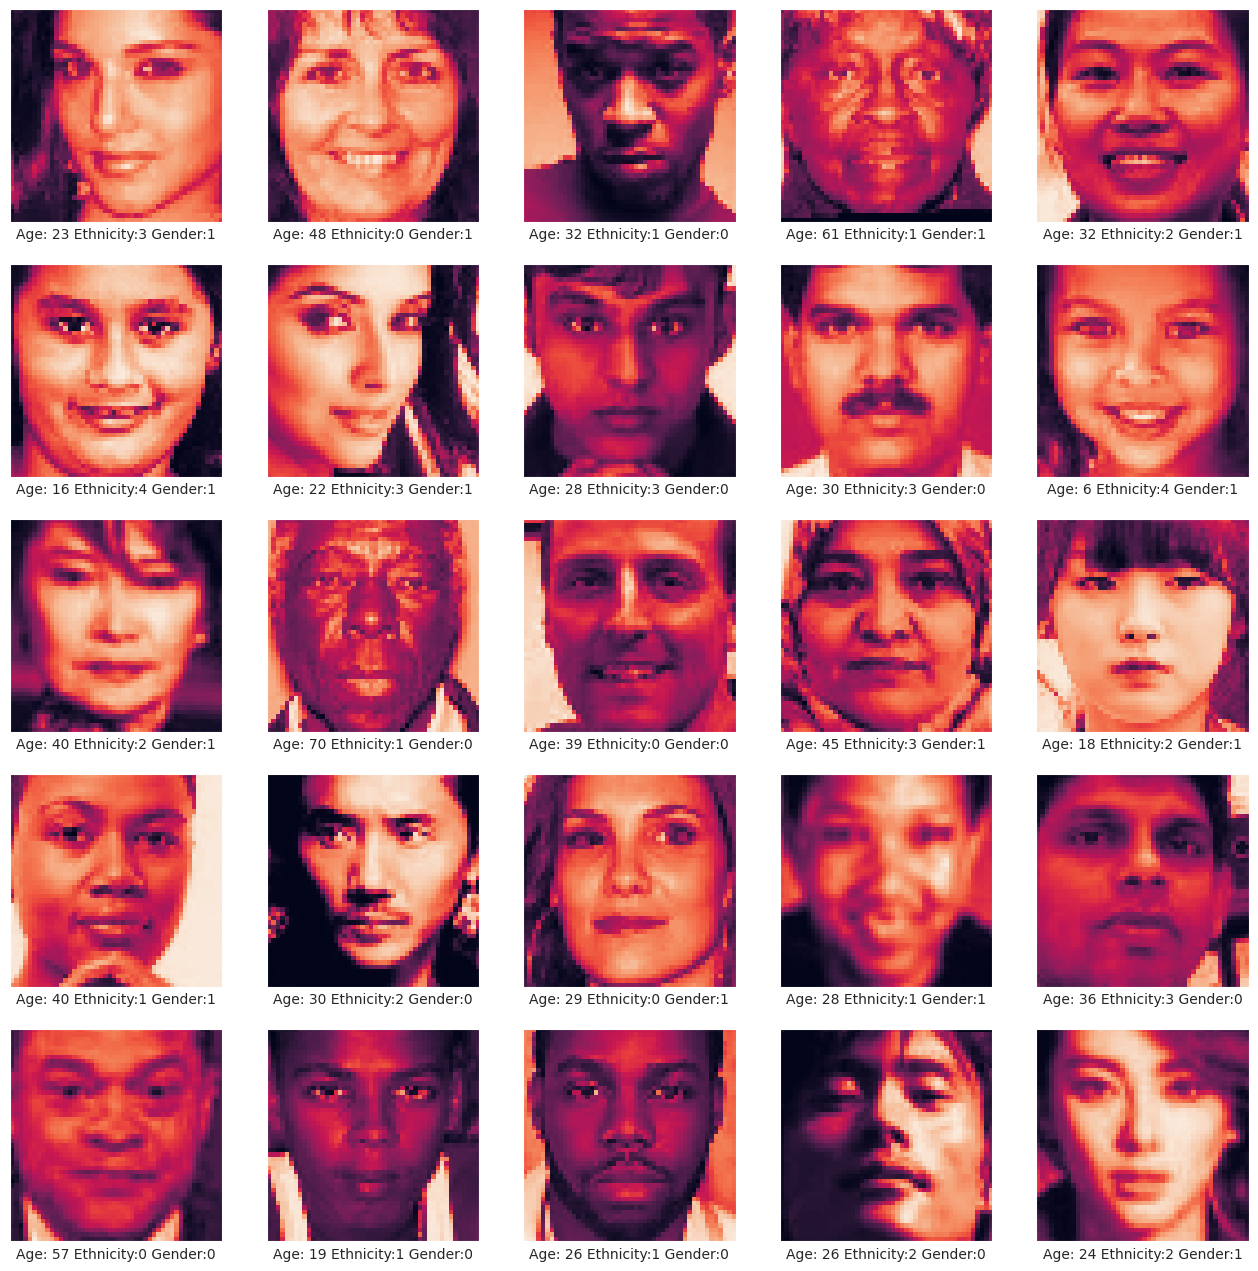

In [42]:
plt.figure(figsize=(16,16))
for i,a in zip(np.random.randint(0, 23705, 25), range(1,26)):
    plt.subplot(5,5,a)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i])
    plt.xlabel(
    "Age: "+str(y['age'].iloc[i])+
    " Ethnicity:"+str(y['ethnicity'].iloc[i])+
    " Gender:"+str(y['gender'].iloc[i]))
plt.show()


In [56]:
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
import plotly.express as px
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy

In [57]:
age_matrix = np.array(y['age'])
gender_matrix = np.array(y['gender'])
ethnicity_matrix = np.array(y['ethnicity'])
age = to_categorical(age_matrix)
gender = to_categorical(gender_matrix, num_classes=2)
ethnicity = to_categorical(ethnicity_matrix, num_classes=5)
print(age, gender, ethnicity)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] [[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [58]:
X = X / 255
X = X / 255

In [59]:
datagen = ImageDataGenerator(
        featurewise_center = False,
    # set input mean to 0 over the dataset
       samplewise_center = False,
    # set each sample mean to 0
       featurewise_std_normalization = False,
    # divide inputs by std of the dataset
       samplewise_std_normalization=False,
    # divide each input by its std
       zca_whitening=False,
    # dimesion reduction
       rotation_range=5,
    # randomly rotate images in the range 5 degrees
       zoom_range = 0.1,
    # Randomly zoom image 10%
       width_shift_range=0.1,
    # randomly shift images horizontally 10%
       height_shift_range=0.1,
    # randomly shift images vertically 10%
       horizontal_flip=False,
    # randomly flip images
        vertical_flip=False  # randomly flip images
)

datagen.fit(X)

In [60]:
from sklearn.model_selection import train_test_split
X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(X,ethnicity, test_size=0.3, random_state=42)

# Gender
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X, gender, test_size=0.3, random_state=42)

# Age
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, age, test_size=0.3, random_state=42)

In [61]:
print(X_train_ethnicity.shape, X_train_gender.shape, X_train_age.shape)

(16593, 48, 48, 1) (16593, 48, 48, 1) (16593, 48, 48, 1)


In [62]:
def my_model(num_classes, activation, loss):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(num_classes, activation=activation))

    model.compile(optimizer='Adam',
              loss= loss,
              metrics=['accuracy'])
    return model

In [63]:
early_stopping = EarlyStopping(patience=10,
                               min_delta=0.001,
                               restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience = 2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr = 0.00001)

In [64]:
epochs = 100  # for better result increase the epochs
batch_size = 64
model_ethnicity = my_model(5,"softmax",'categorical_crossentropy')
history_ethnicity = model_ethnicity.fit(X_train_ethnicity, y_train_ethnicity, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_test_ethnicity,y_test_ethnicity), steps_per_epoch= X_train_ethnicity.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/100
256/259 [============================>.] - ETA: 0s - loss: 1.4740 - accuracy: 0.4167

259/259 [==============================] - 17s 15ms/step - loss: 1.4739 - accuracy: 0.4164 - val_loss: 1.6281 - val_accuracy: 0.1645 - lr: 0.0010
Epoch 2/100
257/259 [============================>.] - ETA: 0s - loss: 1.4565 - accuracy: 0.4228

259/259 [==============================] - 3s 12ms/step - loss: 1.4573 - accuracy: 0.4222 - val_loss: 1.7125 - val_accuracy: 0.0709 - lr: 0.0010
Epoch 3/100
256/259 [============================>.] - ETA: 0s - loss: 1.4555 - accuracy: 0.4227

259/259 [==============================] - 4s 14ms/step - loss: 1.4556 - accuracy: 0.4225 - val_loss: 1.4551 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 4/100
259/259 [==============================] - ETA: 0s - loss: 1.4540 - accuracy: 0.4227

259/259 [==============================] - 3s 13ms/step - loss: 1.4540 - accuracy: 0.4227 - val_loss: 1.4665 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 5/100
257/259 [============================>.] - ETA: 0s - loss: 1.4571 - accuracy: 0.4222

259/259 [==============================] - 3s 13ms/step - loss: 1.4573 - accuracy: 0.4219 - val_loss: 1.4501 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 6/100
258/259 [============================>.] - ETA: 0s - loss: 1.4530 - accuracy: 0.4237

259/259 [==============================] - 3s 13ms/step - loss: 1.4533 - accuracy: 0.4236 - val_loss: 3.5849 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 7/100
258/259 [============================>.] - ETA: 0s - loss: 1.4541 - accuracy: 0.4208

259/259 [==============================] - 3s 13ms/step - loss: 1.4543 - accuracy: 0.4206 - val_loss: 4.7378 - val_accuracy: 0.1645 - lr: 0.0010
Epoch 8/100
256/259 [============================>.] - ETA: 0s - loss: 1.4566 - accuracy: 0.4213

259/259 [==============================] - 3s 13ms/step - loss: 1.4560 - accuracy: 0.4217 - val_loss: 3.9113 - val_accuracy: 0.1645 - lr: 0.0010
Epoch 9/100
257/259 [============================>.] - ETA: 0s - loss: 1.4527 - accuracy: 0.4228

259/259 [==============================] - 3s 12ms/step - loss: 1.4526 - accuracy: 0.4228 - val_loss: 1.4597 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 10/100
258/259 [============================>.] - ETA: 0s - loss: 1.4522 - accuracy: 0.4239

259/259 [==============================] - 4s 14ms/step - loss: 1.4522 - accuracy: 0.4238 - val_loss: 7.6716 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 11/100
256/259 [============================>.] - ETA: 0s - loss: 1.4551 - accuracy: 0.4198

259/259 [==============================] - 3s 12ms/step - loss: 1.4550 - accuracy: 0.4202 - val_loss: 15.2028 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 12/100
257/259 [============================>.] - ETA: 0s - loss: 1.4528 - accuracy: 0.4223

259/259 [==============================] - 3s 13ms/step - loss: 1.4524 - accuracy: 0.4225 - val_loss: 1.4406 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 13/100
257/259 [============================>.] - ETA: 0s - loss: 1.4519 - accuracy: 0.4227

259/259 [==============================] - 3s 13ms/step - loss: 1.4519 - accuracy: 0.4228 - val_loss: 4.6267 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 14/100
259/259 [==============================] - ETA: 0s - loss: 1.4516 - accuracy: 0.4222

259/259 [==============================] - 3s 13ms/step - loss: 1.4516 - accuracy: 0.4222 - val_loss: 5.3641 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 15/100
258/259 [============================>.] - ETA: 0s - loss: 1.4418 - accuracy: 0.4242

259/259 [==============================] - 3s 13ms/step - loss: 1.4419 - accuracy: 0.4242 - val_loss: 797.9706 - val_accuracy: 0.1893 - lr: 0.0010
Epoch 16/100
258/259 [============================>.] - ETA: 0s - loss: 1.4033 - accuracy: 0.4464

259/259 [==============================] - 3s 13ms/step - loss: 1.4031 - accuracy: 0.4464 - val_loss: 476.5009 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 17/100
255/259 [============================>.] - ETA: 0s - loss: 1.3632 - accuracy: 0.4637

259/259 [==============================] - 4s 14ms/step - loss: 1.3631 - accuracy: 0.4633 - val_loss: 133.2962 - val_accuracy: 0.1436 - lr: 0.0010
Epoch 18/100
257/259 [============================>.] - ETA: 0s - loss: 1.3533 - accuracy: 0.4642

259/259 [==============================] - 3s 13ms/step - loss: 1.3535 - accuracy: 0.4639 - val_loss: 574.0618 - val_accuracy: 0.1436 - lr: 0.0010
Epoch 19/100
257/259 [============================>.] - ETA: 0s - loss: 1.3402 - accuracy: 0.4748

259/259 [==============================] - 3s 12ms/step - loss: 1.3411 - accuracy: 0.4746 - val_loss: 144.3798 - val_accuracy: 0.1893 - lr: 0.0010
Epoch 20/100
258/259 [============================>.] - ETA: 0s - loss: 1.3282 - accuracy: 0.4766

259/259 [==============================] - 3s 13ms/step - loss: 1.3278 - accuracy: 0.4767 - val_loss: 1514.9994 - val_accuracy: 0.1436 - lr: 0.0010
Epoch 21/100
256/259 [============================>.] - ETA: 0s - loss: 1.3006 - accuracy: 0.4874

259/259 [==============================] - 4s 14ms/step - loss: 1.3003 - accuracy: 0.4872 - val_loss: 3626.1328 - val_accuracy: 0.1436 - lr: 0.0010
Epoch 22/100
257/259 [============================>.] - ETA: 0s - loss: 1.2634 - accuracy: 0.5026

259/259 [==============================] - 3s 12ms/step - loss: 1.2631 - accuracy: 0.5028 - val_loss: 683.2797 - val_accuracy: 0.4318 - lr: 0.0010


In [65]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [67]:
loss, acc = model_ethnicity.evaluate(X_test_ethnicity, y_test_ethnicity, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 1.4405646324157715
Test Accuracy: 0.43180540204048157


In [71]:
model_gender = my_model(2, "sigmoid", "binary_crossentropy")
history_gender = model_gender.fit(X_train_gender, y_train_gender,
                                 batch_size = batch_size,
                                 epochs = epochs,
                                 validation_data = (X_test_gender, y_test_gender),
                                 steps_per_epoch = X_train_gender.shape[0] // batch_size, callbacks=[early_stopping,learning_rate_reduction])


Epoch 1/100
256/259 [============================>.] - ETA: 0s - loss: 0.6998 - accuracy: 0.5043

259/259 [==============================] - 8s 15ms/step - loss: 0.6997 - accuracy: 0.5043 - val_loss: 0.7002 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 2/100
257/259 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5169

259/259 [==============================] - 3s 12ms/step - loss: 0.6935 - accuracy: 0.5170 - val_loss: 0.7253 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 3/100
255/259 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5183

259/259 [==============================] - 3s 13ms/step - loss: 0.6932 - accuracy: 0.5182 - val_loss: 0.6925 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 4/100
255/259 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5182

259/259 [==============================] - 3s 13ms/step - loss: 0.6928 - accuracy: 0.5185 - val_loss: 0.7011 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 5/100
259/259 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5216

259/259 [==============================] - 4s 14ms/step - loss: 0.6928 - accuracy: 0.5216 - val_loss: 0.7406 - val_accuracy: 0.4740 - lr: 0.0010
Epoch 6/100
259/259 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5197

259/259 [==============================] - 3s 12ms/step - loss: 0.6929 - accuracy: 0.5197 - val_loss: 0.7932 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 7/100
257/259 [============================>.] - ETA: 0s - loss: 0.6924 - accuracy: 0.5206

259/259 [==============================] - 3s 12ms/step - loss: 0.6924 - accuracy: 0.5207 - val_loss: 0.8930 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 8/100
258/259 [============================>.] - ETA: 0s - loss: 0.6924 - accuracy: 0.5199

259/259 [==============================] - 4s 14ms/step - loss: 0.6923 - accuracy: 0.5202 - val_loss: 0.8506 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 9/100
256/259 [============================>.] - ETA: 0s - loss: 0.6922 - accuracy: 0.5226

259/259 [==============================] - 3s 12ms/step - loss: 0.6922 - accuracy: 0.5222 - val_loss: 1.5065 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 10/100
259/259 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5206

259/259 [==============================] - 3s 13ms/step - loss: 0.6923 - accuracy: 0.5206 - val_loss: 1.4624 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 11/100
255/259 [============================>.] - ETA: 0s - loss: 0.6923 - accuracy: 0.5196

259/259 [==============================] - 3s 12ms/step - loss: 0.6924 - accuracy: 0.5190 - val_loss: 1.2747 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 12/100
257/259 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5211

259/259 [==============================] - 4s 14ms/step - loss: 0.6925 - accuracy: 0.5215 - val_loss: 0.7027 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 13/100
255/259 [============================>.] - ETA: 0s - loss: 0.6923 - accuracy: 0.5211

259/259 [==============================] - 3s 13ms/step - loss: 0.6923 - accuracy: 0.5207 - val_loss: 1.9849 - val_accuracy: 0.5260 - lr: 0.0010


In [73]:
loss, acc = model_gender.evaluate(X_test_gender, y_test_gender, verbose=0)
print("Test loss: {}".format(loss))
print("Test Accuracy: {}".format(acc))

Test loss: 0.6925047039985657
Test Accuracy: 0.5260123610496521


In [74]:
model_age.save('age.h5')

In [75]:
model_gender.save('gender.h5')